In [2]:
pip install wfdb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 97.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wfdb
from wfdb import processing

In [27]:
folder_path = '/content/drive/MyDrive/data/Final Dataset'


In [23]:

# Path to the folder containing ECG data and the labels file

# Read the labels CSV
labels = pd.read_csv(f'{folder_path}labels.csv')

# Get the list of record names
file_names = labels['Record Name'].values

# Preallocate a list to store ECG signals (use list instead of ndarray if lengths vary)
ecg_signals = []

for file_name in file_names:
    # Read the WFDB record
    record = wfdb.rdrecord(f"{folder_path}/{file_name}")
    fs = record.fs  # Sampling frequency
    ecg_signal = record.p_signal[:, 0]  # First channel of ECG
    ecg_signals.append(ecg_signal)

# If all ECG signals are the same length, convert to ndarray:
data_array = np.array(ecg_signals)

In [7]:
data_array.shape

(73, 1920000)

In [8]:

print(fs)

8000


In [12]:
def extract_qrs_indices(signal, sample_rate, rr_interval_max_length):
    """
    Extract QRS indices using local peak detection based on radius derived from RR interval length.
    """
    qrs_radius = int(((1 / 1000) * rr_interval_max_length) / (1 / sample_rate))
    qrs_inds = processing.find_local_peaks(sig=signal, radius=qrs_radius)
    return qrs_inds


In [11]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, lowcut=5, highcut=15, fs=8000, order=4):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

from scipy.signal import resample

def downsample_signal(signal, original_fs, target_fs=360):
    factor = int(original_fs / target_fs)
    num_samples = int(len(signal) * target_fs / original_fs)
    return resample(signal, num_samples), target_fs

def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)


In [18]:
# QRS annotations will be stored here
qrs_annotations = []
fs = 8000
# Loop over all files

for i, raw_signal in enumerate(data_array):
    # Run QRS detection
    # filtered = bandpass_filter(raw_signal, fs=fs)
    # downsampled, new_fs = downsample_signal(filtered, fs, target_fs=360)
    # normalized = normalize(downsampled)
    print(f"{i}: Filtered, downsampled, and normalized {raw_signal.shape}")

    # QRS Detection
    qrs_peaks = extract_qrs_indices(signal=raw_signal, sample_rate=8000, rr_interval_max_length=1200 )

    qrs_annotations.append(qrs_peaks)

    print(f"{i}: Detected {len(qrs_peaks)} QRS peaks")

0: Filtered, downsampled, and normalized (1920000,)


KeyboardInterrupt: 

In [34]:
import os
import numpy as np
import wfdb
from wfdb import processing
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

def butter_bandpass(lowcut, highcut, fs, order=4):
    if lowcut >= highcut:
        raise ValueError(f"lowcut should be less than highcut: {lowcut} >= {highcut}")
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    return butter(order, [low, high], btype='band')

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def normalize_signal(signal):
    signal = np.nan_to_num(signal)  # Convert NaN to 0
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal) + 1e-8)  # Add small epsilon to avoid division by zero

def extract_rr_features(qrs_inds):
    rr_prev, rr_post, rr_ratio, rr_local = [], [], [], []
    rrs = np.diff(qrs_inds)

    avg_rr = np.mean(rrs) if len(rrs) > 0 else 1.0
    for i in range(len(qrs_inds)):
        prev = rrs[i-1] if i > 0 else avg_rr
        post = rrs[i] if i < len(rrs) else avg_rr
        local = np.mean(rrs[max(0, i-5):i+1]) if i > 0 else avg_rr

        rr_prev.append(prev / avg_rr)
        rr_post.append(post / avg_rr)
        rr_ratio.append((prev / post) if post != 0 else 1.0)
        rr_local.append(local / avg_rr if local != 0 else 1.0)

    return rr_prev, rr_post, rr_ratio, rr_local

def plot_qrs(signal, qrs_inds, fs, filename, save_dir):
    time = np.arange(len(signal)) / fs
    hr = np.diff(qrs_inds) / fs
    bpm = 60.0 / hr

    plt.figure(figsize=(12, 4))
    plt.plot(time, signal, label='ECG')
    plt.plot(qrs_inds / fs, signal[qrs_inds], 'ro', label='QRS Peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'ECG Signal with QRS Peaks - {filename}')
    plt.legend()
    plt.savefig(os.path.join(save_dir, f"{filename}_qrs.png"))
    plt.close()

    return bpm

def preprocess_and_extract(filepath, filename, fs_target=250, chan=0,
                         lowcut=0.5, highcut=45.0, normalize=True, save_dir='./output'):
    try:
        os.makedirs(save_dir, exist_ok=True)

        # Load ECG signal
        record = wfdb.rdrecord(os.path.join(filepath, filename))
        signal = record.p_signal[:, chan]
        fs = record.fs

        # Handle NaN values
        signal = np.nan_to_num(signal)

        # Resample if necessary
        if fs != fs_target:
            signal, _ = processing.resample_sig(signal, fs, fs_target)
            fs = fs_target

        if normalize:
            signal = normalize_signal(signal)

        # Filter
        signal = apply_bandpass_filter(signal, lowcut, highcut, fs)

        # Detect QRS peaks
        qrs_inds = processing.gqrs_detect(sig=signal, fs=fs)

        # Plot
        bpm = plot_qrs(signal, qrs_inds, fs, filename, save_dir)

        # Extract RR features
        rr_prev, rr_post, rr_ratio, rr_local = extract_rr_features(qrs_inds)

        # Save data
        np.save(os.path.join(save_dir, f"{filename}_signal.npy"), signal)
        np.save(os.path.join(save_dir, f"{filename}_qrs_inds.npy"), qrs_inds)
        np.save(os.path.join(save_dir, f"{filename}_rr_features.npy"),
                np.array([rr_prev, rr_post, rr_ratio, rr_local]))

        return {
            "signal": signal,
            "qrs_inds": qrs_inds,
            "rr_features": {
                "prev": rr_prev,
                "post": rr_post,
                "ratio": rr_ratio,
                "local": rr_local
            },
            "bpm": bpm
        }
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")
        return None

def process_multiple_files(filepath, filenames, fs_target=250, lowcut=0.5, highcut=45.0,
                          normalize=True, save_dir='./output_features'):
    os.makedirs(save_dir, exist_ok=True)
    results = {}

    for filename in filenames:
        print(f"Processing {filename}...")
        result = preprocess_and_extract(
            filepath=filepath,
            filename=filename,
            fs_target=fs_target,
            chan=0,
            lowcut=lowcut,
            highcut=highcut,
            normalize=normalize,
            save_dir=save_dir
        )
        if result is not None:
            results[filename] = result
            print(f"Successfully processed {filename}")
        else:
            print(f"Failed to process {filename}")

    return results

Processing ECGPCG0001...
Successfully processed ECGPCG0001
Processing ECGPCG0013...
Successfully processed ECGPCG0013
Processing ECGPCG0019_1...
Successfully processed ECGPCG0019_1
Processing ECGPCG0019_2...
Successfully processed ECGPCG0019_2
Processing ECGPCG0019_3...
Error processing ECGPCG0019_3: arrays used as indices must be of integer (or boolean) type
Failed to process ECGPCG0019_3
Processing ECGPCG0019_4...
Successfully processed ECGPCG0019_4
Processing ECGPCG0019_5...
Successfully processed ECGPCG0019_5
Processing ECGPCG0010...
Successfully processed ECGPCG0010
Processing ECGPCG0018_1...
Successfully processed ECGPCG0018_1
Processing ECGPCG0018_2...
Successfully processed ECGPCG0018_2
Processing ECGPCG0018_3...
Successfully processed ECGPCG0018_3
Processing ECGPCG0018_4...
Successfully processed ECGPCG0018_4
Processing ECGPCG0018_5...
Successfully processed ECGPCG0018_5
Processing ECGPCG0024...
Successfully processed ECGPCG0024
Processing ECGPCG0015...
Successfully processed 

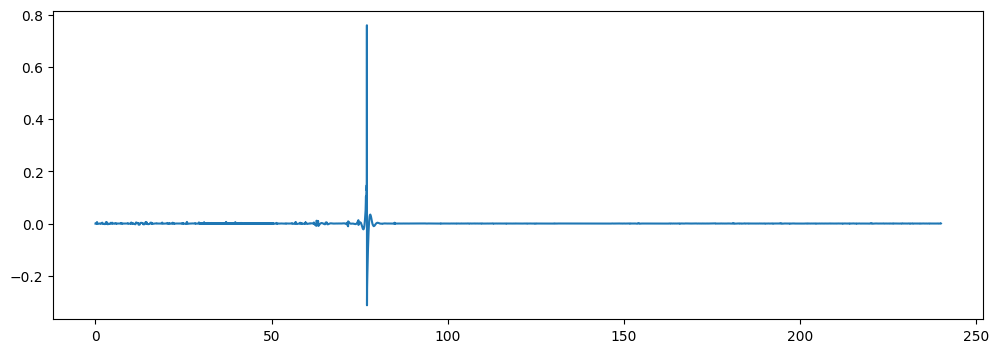

In [35]:
# Example usage:
# folder_path = "/content/drive/MyDrive/data/Final Dataset"
# file_names = ["ECGPCG0001", "ECGPCG0002"]  # Replace with your actual filenames
fs = 250  # Your target sampling frequency

results = process_multiple_files(
    filepath=folder_path,
    filenames=file_names,
    fs_target=fs,
    lowcut=0.5,
    highcut=45.0,
    normalize=True,
    save_dir='./output_features'
)

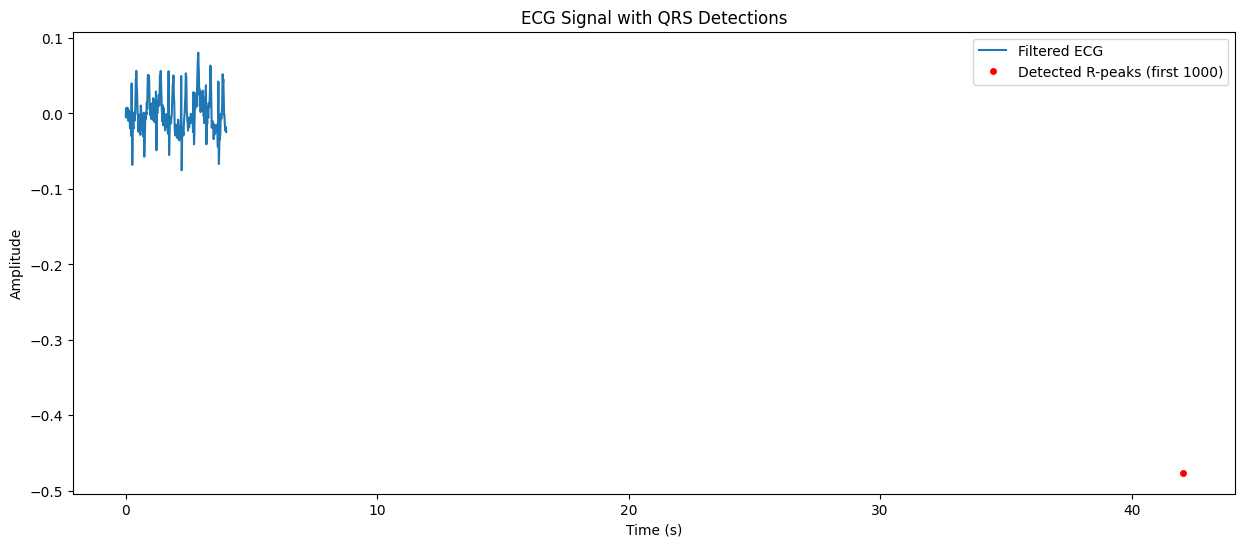

Average BPM: 53.2
Number of detected beats: 11
RR interval stats (ms): Mean=10884.0, Std=12128.2


In [103]:
def validate_with_plots(results, sample_filename, save_dir='./validation'):
    os.makedirs(save_dir, exist_ok=True)
    data = results[sample_filename]

    # Create time axis
    fs = 250  # Your sampling frequency
    time = np.arange(len(data['signal'])) / fs

    # Plot original signal with detected peaks
    plt.figure(figsize=(15, 6))
    plt.plot(time[:1000], data['signal'][:1000], label='Filtered ECG')
    n_peaks_to_plot = min(1, len(data['qrs_inds']))  # Ensure we don't exceed available peaks
    plt.plot(data['qrs_inds'][:n_peaks_to_plot]/fs,
            data['signal'][data['qrs_inds'][:n_peaks_to_plot]],
            'ro', markersize=4, label='Detected R-peaks (first 1000)')

    plt.title('ECG Signal with QRS Detections')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

    # Print key metrics
    print(f"Average BPM: {np.mean(data['bpm']):.1f}")
    print(f"Number of detected beats: {len(data['qrs_inds'])}")
    print(f"RR interval stats (ms): Mean={np.mean(np.diff(data['qrs_inds'])/fs*1000):.1f}, "
          f"Std={np.std(np.diff(data['qrs_inds'])/fs*1000):.1f}")
# Usage
validate_with_plots(results, 'ECGPCG0069')  # Replace with your filename

In [53]:

def load_processed_data(output_dir, filename):
    """Load your previously processed data"""
    data = {
        'signal': np.load(os.path.join(output_dir, f"{filename}_signal.npy")),
        'qrs_inds': np.load(os.path.join(output_dir, f"{filename}_qrs_inds.npy")),
        'rr_features': np.load(os.path.join(output_dir, f"{filename}_rr_features.npy"))
    }
    return data

In [90]:
def remove_rr_outliers(rr_intervals, method='iqr', threshold=1.5):
    """
    Remove outliers from RR intervals using specified method.

    Args:
        rr_intervals: Array of RR intervals in ms
        method: 'iqr' (interquartile range) or 'zscore'
        threshold: Threshold multiplier for outlier detection

    Returns:
        Cleaned RR intervals array
    """
    if len(rr_intervals) < 4:  # Not enough points for outlier detection
        return rr_intervals

    if method == 'iqr':
        # IQR method (more robust for non-normal distributions)
        q1, q3 = np.percentile(rr_intervals, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - threshold*iqr
        upper_bound = q3 + threshold*iqr
        mask = (rr_intervals >= lower_bound) & (rr_intervals <= upper_bound)

    elif method == 'zscore':
        # Z-score method (for normal distributions)
        z = np.abs((rr_intervals - np.mean(rr_intervals)) / np.std(rr_intervals))
        mask = z < threshold

    else:
        raise ValueError("Invalid method. Use 'iqr' or 'zscore'")

    return rr_intervals[mask]

def calculate_rr_statistics(qrs_inds, fs=250):
    """
    Calculate comprehensive RR statistics with outlier removal

    Args:
        qrs_inds: Array of QRS peak indices
        fs: Sampling frequency in Hz

    Returns:
        Dictionary of RR statistics
    """
    if len(qrs_inds) < 2:
        return {}

    # Convert to RR intervals in ms
    rr_intervals = np.diff(qrs_inds) / fs * 1000

    # Remove outliers
    clean_rr = remove_rr_outliers(rr_intervals)

    # Basic statistics
    stats = {
        'rr_num_raw': len(rr_intervals),
        'rr_num_clean': len(clean_rr),
        'rr_outliers_removed': len(rr_intervals) - len(clean_rr),
    }

    if len(clean_rr) > 0:
        # Central tendency
        stats.update({
            'rr_mean': np.mean(clean_rr),
            'rr_median': np.median(clean_rr),
            'rr_mode': float(most_common_value(clean_rr)),
        })

        # Dispersion
        stats.update({
            'rr_std': np.std(clean_rr),
            'rr_iqr': np.percentile(clean_rr, 75) - np.percentile(clean_rr, 25),
            'rr_range': np.max(clean_rr) - np.min(clean_rr),
        })

        # Boundaries
        stats.update({
            'rr_min': np.min(clean_rr),
            'rr_max': np.max(clean_rr),
            'rr_p5': np.percentile(clean_rr, 5),
            'rr_p95': np.percentile(clean_rr, 95),
        })

        # Heart rate conversion
        stats.update({
            'hr_mean': 60000 / stats['rr_mean'],
            'hr_median': 60000 / stats['rr_median'],
            'hr_std': np.std(60000 / clean_rr),
        })

        # Variability metrics (require minimum 4 intervals)
        if len(clean_rr) >= 4:
            rr_diff = np.diff(clean_rr)
            stats.update({
                'rmssd': np.sqrt(np.mean(rr_diff ** 2)),
                'nn50': np.sum(np.abs(rr_diff) > 50),
                'pnn50': (np.sum(np.abs(rr_diff) > 50) / len(rr_diff) * 100),
            })

    return stats

def most_common_value(arr, bins=20):
    """Helper function to find modal value"""
    hist, bin_edges = np.histogram(arr, bins=bins)
    return bin_edges[np.argmax(hist)]

In [91]:
import pandas as pd
import numpy as np
import os

def remove_rr_outliers(rr_intervals, method='iqr', threshold=1.5):
    """
    Remove outliers from RR intervals using specified method.

    Args:
        rr_intervals: Array of RR intervals in ms
        method: 'iqr' (interquartile range) or 'zscore'
        threshold: Threshold multiplier for outlier detection

    Returns:
        Cleaned RR intervals array
    """
    if len(rr_intervals) < 4:  # Not enough points for outlier detection
        return rr_intervals

    if method == 'iqr':
        # IQR method (more robust for non-normal distributions)
        q1, q3 = np.percentile(rr_intervals, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - threshold*iqr
        upper_bound = q3 + threshold*iqr
        mask = (rr_intervals >= lower_bound) & (rr_intervals <= upper_bound)

    elif method == 'zscore':
        # Z-score method (for normal distributions)
        z = np.abs((rr_intervals - np.mean(rr_intervals)) / np.std(rr_intervals))
        mask = z < threshold

    else:
        raise ValueError("Invalid method. Use 'iqr' or 'zscore'")

    return rr_intervals[mask]

def calculate_rr_statistics(qrs_inds, fs=250):
    """
    Calculate comprehensive RR statistics with outlier removal

    Args:
        qrs_inds: Array of QRS peak indices
        fs: Sampling frequency in Hz

    Returns:
        Dictionary of RR statistics
    """
    if len(qrs_inds) < 2:
        return {}

    # Convert to RR intervals in ms
    rr_intervals = np.diff(qrs_inds) / fs * 1000

    # Remove outliers
    clean_rr = remove_rr_outliers(rr_intervals)

    # Basic statistics
    stats = {
        'rr_num_raw': len(rr_intervals),
        'rr_num_clean': len(clean_rr),
        'rr_outliers_removed': len(rr_intervals) - len(clean_rr),
    }

    if len(clean_rr) > 0:
        # Central tendency
        stats.update({
            'mean_rr': np.mean(clean_rr),
            'median_rr': np.median(clean_rr),
            'mode_rr': float(np.argmax(np.bincount(clean_rr.astype(int)))),
        })

        # Dispersion
        stats.update({
            'std_rr': np.std(clean_rr),
            'iqr_rr': np.percentile(clean_rr, 75) - np.percentile(clean_rr, 25),
            'range_rr': np.max(clean_rr) - np.min(clean_rr),
        })

        # Boundaries
        stats.update({
            'min_rr': np.min(clean_rr),
            'max_rr': np.max(clean_rr),
            'p5_rr': np.percentile(clean_rr, 5),
            'p95_rr': np.percentile(clean_rr, 95),
        })

        # Heart rate conversion
        stats.update({
            'mean_hr': 60000 / stats['mean_rr'],
            'median_hr': 60000 / stats['median_rr'],
            'hr_std': np.std(60000 / clean_rr),
        })

        # Variability metrics (require minimum 4 intervals)
        if len(clean_rr) >= 4:
            rr_diff = np.diff(clean_rr)
            stats.update({
                'rmssd': np.sqrt(np.mean(rr_diff ** 2)),
                'nn50': np.sum(np.abs(rr_diff) > 50),
                'pnn50': (np.sum(np.abs(rr_diff) > 50) / len(rr_diff)) * 100,
            })

    return stats

def load_features_to_dataframe(output_dir, filenames, fs=250):
    """
    Load all feature files into a pandas DataFrame
    Args:
        output_dir: Directory containing your saved .npy files
        filenames: List of filenames (without extensions)
        fs: Sampling frequency
    Returns:
        pandas DataFrame containing all features
    """
    # Initialize empty lists to store features
    data_rows = []

    for filename in filenames:
        try:
            # Initialize row dictionary with filename
            row = {'filename': filename}

            # Load basic data if exists
            signal_path = os.path.join(output_dir, f"{filename}_signal.npy")
            qrs_path = os.path.join(output_dir, f"{filename}_qrs_inds.npy")
            rr_path = os.path.join(output_dir, f"{filename}_rr_features.npy")

            if os.path.exists(signal_path):
                signal = np.load(signal_path)
                row['signal_length'] = len(signal)
                row['signal_mean'] = np.mean(signal)
                row['signal_std'] = np.std(signal)

            if os.path.exists(qrs_path):
                qrs_inds = np.load(qrs_path)
                row['num_beats'] = len(qrs_inds)

                # Calculate comprehensive RR statistics with outlier removal
                rr_stats = calculate_rr_statistics(qrs_inds, fs)
                if rr_stats:
                    row.update(rr_stats)

            # Load RR features if exists
            if os.path.exists(rr_path):
                rr_features = np.load(rr_path, allow_pickle=True)
                if rr_features.ndim > 0:  # Check if not empty
                    row.update({
                        'rr_prev_mean': np.mean(rr_features[0]),
                        'rr_post_mean': np.mean(rr_features[1]),
                        'rr_ratio_mean': np.mean(rr_features[2]),
                        'rr_local_mean': np.mean(rr_features[3])
                    })

            # Load enhanced features if exists
            enhanced_path = os.path.join(output_dir, f"{filename}_enhanced_features.npy")
            if os.path.exists(enhanced_path):
                enhanced_features = np.load(enhanced_path, allow_pickle=True).item()
                row.update(enhanced_features)

            data_rows.append(row)

        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            continue

    # Create DataFrame
    df = pd.DataFrame(data_rows)

    # Set filename as index
    df.set_index('filename', inplace=True)

    return df

In [92]:
# Example usage:
output_directory = './output_features'  # Your output folder

# Load all features into a DataFrame
features_df = load_features_to_dataframe(output_directory, file_names)

# Display the DataFrame
print(features_df.head())

# Save to CSV for later use
features_df.to_csv(os.path.join(output_directory, 'all_features.csv'))

# Basic statistics
print("\nSummary Statistics:")


              signal_length  signal_mean  signal_std  num_beats  rr_num_raw  \
filename                                                                      
ECGPCG0001          60000.0     0.000227    0.109764      557.0       556.0   
ECGPCG0013          60000.0    -0.000018    0.062707      240.0       239.0   
ECGPCG0019_1        60000.0    -0.000031    0.168441      223.0       222.0   
ECGPCG0019_2        60000.0    -0.000038    0.159076      254.0       253.0   
ECGPCG0019_3            NaN          NaN         NaN        NaN         NaN   

              rr_num_clean  rr_outliers_removed     mean_rr  median_rr  \
filename                                                                 
ECGPCG0001           556.0                  0.0  430.345324      428.0   
ECGPCG0013           239.0                  0.0  998.577406      988.0   
ECGPCG0019_1         209.0                 13.0  707.135135      520.0   
ECGPCG0019_2         235.0                 18.0  899.778656      512.0   
EC

In [96]:
features_df.tail()

,signal_length,signal_mean,signal_std,num_beats,rr_num_raw,rr_num_clean,rr_outliers_removed,mean_rr,median_rr,mode_rr,...,nn50,pnn50,rr_prev_mean,rr_post_mean,rr_ratio_mean,rr_local_mean,mean_qrs_width,std_qrs_width,mean_qrs_amplitude,std_qrs_amplitude
filename,,,,,,,,,,,,,,,,,,,,,
ECGPCG0067,60000.0,-4.503082e-06,0.06762,470.0,469.0,401.0,68.0,506.746269,416.0,412.0,...,1.0,0.250000,1.0,1.0,1.108177,1.000229,13.880851,12.184515,0.366991,0.056419
ECGPCG0066,60000.0,-1.214883e-05,0.08495,327.0,326.0,310.0,16.0,731.411043,684.0,380.0,...,141.0,45.631068,1.0,1.0,1.207797,1.001489,28.256881,4.814105,0.300054,0.025976
ECGPCG0065,60000.0,4.613844e-05,0.06423,36.0,35.0,29.0,6.0,5605.485714,1400.0,640.0,...,24.0,85.714286,1.0,1.0,3.830081,1.096792,26.666667,29.918408,0.343142,0.142704
ECGPCG0069,60000.0,4.312281e-07,0.05081,11.0,10.0,9.0,1.0,10884.000000,8964.0,324.0,...,8.0,100.000000,1.0,1.0,15.923163,0.952084,22.909091,26.095818,0.548500,0.202008
ECGPCG0002,60000.0,4.312281e-07,0.05081,11.0,10.0,9.0,1.0,10884.000000,8964.0,324.0,...,8.0,100.000000,1.0,1.0,15.923163,0.952084,22.909091,26.095818,0.548500,0.202008


In [94]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=features_df)

https://docs.google.com/spreadsheets/d/1mk-HZldrT9fHN0RYaV5MHWXgYu1Ilg1pxHB_2mo77Os/edit#gid=0


In [85]:
def handle_missing_data(df, threshold=0.8):
    """
    Clean the DataFrame by:
    1. Dropping columns with too many missing values
    2. Filling remaining missing values with median
    """
    # Drop columns with more than threshold% missing values
    cols_to_drop = df.columns[df.isnull().mean() > threshold]
    df = df.drop(cols_to_drop, axis=1)

    # Fill remaining missing values with column median
    for col in df.columns:
        df[col] = df[col].fillna(df[col].median())

    return df

# Usage:
cleaned_df = handle_missing_data(features_df)

In [83]:
# Configuration
output_directory = './output_features'  # Your output folder
sampling_rate = 250                    # Your sampling frequency

# 1. Process all recordings
feature_df = process_all_recordings(output_directory, sampling_rate)

# 2. Save results
feature_df.to_csv(os.path.join(output_directory, 'time_domain_features.csv'))
feature_df.to_pickle(os.path.join(output_directory, 'time_domain_features.pkl'))

# 3. Analyze features
analyze_time_domain_features(feature_df, save_dir=output_directory)

# 4. Show the resulting DataFrame
print("\nFirst 5 records in the feature DataFrame:")
display(feature_df.head())

Error processing ECGPCG0021_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0033_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0002_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0018_1_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0001_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0046_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0028_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0014_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0034_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0063_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0061_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0059_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0017_4_qrs_inds.npy: 'int' object is not subscriptable
Error pr

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-77-2c2070d90a63>:54: RuntimeWarning: invalid value encountered in scalar divide
  'hrv_pnn50': (np.sum(np.abs(rr_diff) > 50) / len(rr_diff)) * 100,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / 

Error processing ECGPCG0010_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0018_3_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0051_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0067_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0024_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0017_5_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0017_2_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0055_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0031_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0068_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0011_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0054_qrs_inds.npy: 'int' object is not subscriptable
Error processing ECGPCG0047_qrs_inds.npy: 'int' object is not subscriptable
Error 

ValueError: No valid features extracted from any files

In [59]:
import pandas as pd
import numpy as np
import os

def load_features_to_dataframe(output_dir, filenames, fs=250):
    """
    Load all feature files into a pandas DataFrame
    Args:
        output_dir: Directory containing your saved .npy files
        filenames: List of filenames (without extensions)
        fs: Sampling frequency
    Returns:
        pandas DataFrame containing all features
    """
    # Initialize empty lists to store features
    data_rows = []

    for filename in filenames:
        try:
            # Initialize row dictionary with filename
            row = {'filename': filename}

            # Load basic data if exists
            signal_path = os.path.join(output_dir, f"{filename}_signal.npy")
            qrs_path = os.path.join(output_dir, f"{filename}_qrs_inds.npy")
            rr_path = os.path.join(output_dir, f"{filename}_rr_features.npy")

            if os.path.exists(signal_path):
                signal = np.load(signal_path)
                row['signal_length'] = len(signal)
                row['signal_mean'] = np.mean(signal)
                row['signal_std'] = np.std(signal)

            if os.path.exists(qrs_path):
                qrs_inds = np.load(qrs_path)
                row['num_beats'] = len(qrs_inds)

                # Calculate basic RR statistics
                if len(qrs_inds) > 1:
                    rr_intervals = np.diff(qrs_inds) / fs * 1000  # in ms
                    row.update({
                        'mean_rr': np.mean(rr_intervals),
                        'std_rr': np.std(rr_intervals),
                        'min_rr': np.min(rr_intervals),
                        'max_rr': np.max(rr_intervals),
                        'mean_hr': 60000 / np.mean(rr_intervals)  # in bpm
                    })

            # Load RR features if exists
            if os.path.exists(rr_path):
                rr_features = np.load(rr_path, allow_pickle=True)
                if rr_features.ndim > 0:  # Check if not empty
                    row.update({
                        'rr_prev_mean': np.mean(rr_features[0]),
                        'rr_post_mean': np.mean(rr_features[1]),
                        'rr_ratio_mean': np.mean(rr_features[2]),
                        'rr_local_mean': np.mean(rr_features[3])
                    })

            # Load enhanced features if exists
            enhanced_path = os.path.join(output_dir, f"{filename}_enhanced_features.npy")
            if os.path.exists(enhanced_path):
                enhanced_features = np.load(enhanced_path, allow_pickle=True).item()
                row.update(enhanced_features)

            data_rows.append(row)

        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            continue

    # Create DataFrame
    df = pd.DataFrame(data_rows)

    # Set filename as index
    df.set_index('filename', inplace=True)

    return df

In [62]:
# Example usage:
output_directory = './output_features'  # Your output folder

# Load all features into a DataFrame
features_df = load_features_to_dataframe(output_directory, file_names)

# Display the DataFrame
print(features_df.head())

# Save to CSV for later use
features_df.to_csv(os.path.join(output_directory, 'all_features.csv'))

# Basic statistics
print("\nSummary Statistics:")
features_df.describe()

              signal_length  signal_mean  signal_std  num_beats     mean_rr  \
filename                                                                      
ECGPCG0001          60000.0     0.000227    0.109764      557.0  430.345324   
ECGPCG0013          60000.0    -0.000018    0.062707      240.0  998.577406   
ECGPCG0019_1        60000.0    -0.000031    0.168441      223.0  707.135135   
ECGPCG0019_2        60000.0    -0.000038    0.159076      254.0  899.778656   
ECGPCG0019_3            NaN          NaN         NaN        NaN         NaN   

                   std_rr  min_rr   max_rr     mean_hr  rr_prev_mean  \
filename                                                               
ECGPCG0001      18.705484   400.0    472.0  139.422916           1.0   
ECGPCG0013     121.699753   704.0   1284.0   60.085477           1.0   
ECGPCG0019_1   487.642434   172.0   3828.0   84.849411           1.0   
ECGPCG0019_2  3220.661452   204.0  50532.0   66.683067           1.0   
ECGPCG0019_3  

,signal_length,signal_mean,signal_std,num_beats,mean_rr,std_rr,min_rr,max_rr,mean_hr,rr_prev_mean,rr_post_mean,rr_ratio_mean,rr_local_mean,rmssd,mean_qrs_width,std_qrs_width,mean_qrs_amplitude,std_qrs_amplitude
count,72.0,7.200000e+01,72.000000,72.000000,72.000000,72.000000,72.000000,72.00000,72.000000,7.200000e+01,7.200000e+01,72.000000,72.000000,71.000000,72.000000,72.000000,72.000000,72.000000
mean,60000.0,1.604395e-05,0.086991,337.055556,2508.287503,2688.361592,568.777778,10948.50000,86.117135,1.000000e+00,1.000000e+00,1.740944,1.009467,3966.341196,36.440161,16.670523,0.452607,0.075826
std,0.0,9.540533e-05,0.035273,174.182023,6277.820128,9077.604558,597.053286,28042.82682,42.048778,9.223146e-17,8.436707e-17,2.656289,0.047864,14753.399632,25.026204,15.902743,0.190213,0.059176
min,60000.0,-3.250107e-04,0.034194,2.000000,334.321678,0.000000,172.000000,472.00000,1.582919,1.000000e+00,1.000000e+00,1.000000,0.949901,4.258325,9.039216,1.239007,0.136097,0.017266
25%,60000.0,-2.603893e-05,0.060553,243.750000,530.208715,60.146628,324.000000,1033.00000,65.354352,1.000000e+00,1.000000e+00,1.002555,0.999990,57.662525,18.453421,5.694012,0.303861,0.040252
50%,60000.0,7.745030e-07,0.085749,361.500000,661.959033,129.270054,410.000000,1610.00000,90.754211,1.000000e+00,1.000000e+00,1.029792,1.000430,189.639592,30.197274,11.010409,0.442156,0.056352
75%,60000.0,5.170728e-05,0.109764,451.250000,919.260222,304.169698,560.000000,2758.00000,113.176432,1.000000e+00,1.000000e+00,1.161379,1.002510,418.225477,42.536268,25.613432,0.575465,0.080340
max,60000.0,3.438913e-04,0.182069,716.000000,37904.666667,67650.163929,3788.000000,188988.00000,179.467871,1.000000e+00,1.000000e+00,15.923163,1.293800,114007.466829,131.142857,64.215468,0.847006,0.283652


from matplotlib import pyplot as plt
_df_0['signal_length'].plot(kind='hist', bins=20, title='signal_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['signal_mean'].plot(kind='hist', bins=20, title='signal_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['signal_std'].plot(kind='hist', bins=20, title='signal_std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['num_beats'].plot(kind='hist', bins=20, title='num_beats')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='signal_length', y='signal_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='signal_mean', y='signal_std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='signal_std', y='num_beats', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='num_beats', y='mean_rr', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['signal_length'].plot(kind='line', figsize=(8, 4), title='signal_length')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['signal_mean'].plot(kind='line', figsize=(8, 4), title='signal_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['signal_std'].plot(kind='line', figsize=(8, 4), title='signal_std')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['num_beats'].plot(kind='line', figsize=(8, 4), title='num_beats')
plt.gca().spines[['top', 'right']].set_visible(False)

In [63]:
features_df

,signal_length,signal_mean,signal_std,num_beats,mean_rr,std_rr,min_rr,max_rr,mean_hr,rr_prev_mean,rr_post_mean,rr_ratio_mean,rr_local_mean,rmssd,mean_qrs_width,std_qrs_width,mean_qrs_amplitude,std_qrs_amplitude
filename,,,,,,,,,,,,,,,,,,
ECGPCG0001,60000.0,2.268565e-04,0.109764,557.0,430.345324,18.705484,400.0,472.0,139.422916,1.0,1.0,1.000053,1.000280,4.258325,10.197487,4.074327,0.718332,0.064102
ECGPCG0013,60000.0,-1.787078e-05,0.062707,240.0,998.577406,121.699753,704.0,1284.0,60.085477,1.0,1.0,1.003823,1.001275,92.442487,29.866667,2.028683,0.678659,0.036573
ECGPCG0019_1,60000.0,-3.128399e-05,0.168441,223.0,707.135135,487.642434,172.0,3828.0,84.849411,1.0,1.0,1.379637,1.010213,667.279911,61.686099,45.046962,0.763527,0.177188
ECGPCG0019_2,60000.0,-3.837008e-05,0.159076,254.0,899.778656,3220.661452,204.0,50532.0,66.683067,1.0,1.0,1.789615,1.001525,4409.804941,70.629921,52.875251,0.524566,0.037202
ECGPCG0019_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ECGPCG0067,60000.0,-4.503082e-06,0.067620,470.0,506.746269,228.440522,380.0,2560.0,118.402451,1.0,1.0,1.108177,1.000229,337.851684,13.880851,12.184515,0.366991,0.056419
ECGPCG0066,60000.0,-1.214883e-05,0.084950,327.0,731.411043,396.426921,340.0,2212.0,82.033216,1.0,1.0,1.207797,1.001489,522.686645,28.256881,4.814105,0.300054,0.025976
ECGPCG0065,60000.0,4.613844e-05,0.064230,36.0,5605.485714,10184.251824,340.0,48912.0,10.703800,1.0,1.0,3.830081,1.096792,12020.790695,26.666667,29.918408,0.343142,0.142704


In [64]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=features_df)

https://docs.google.com/spreadsheets/d/1z9ye7Z2sleTDt3ST8qqOYQKj0k3znZxAsEDtvlmu4qU/edit#gid=0


In [104]:
!cp -r /content/output_features /content/drive/MyDrive/data
